In [1]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import time

from mtj.init import init_m
from mtj.llg_heun import LLG_Heun
from mtj.constants import VACUUM_PERMEABILITY
from mtj.typing import MaterialProps

### Comparison between constant field approximation and recomputation in the Heun intermediate step

The same simulations on a thin film of soft magnetic material (Permalloy) are performed with and without intermediate recomputation of the total magnetic field in the intermediate step in the Heun method. Thermal fluctuations are considered, but STT effect is not included. No external magnetic field is applied here and an arbitrary initial magnetization is chosen.

**Physical Constants Used**

| Constant | Symbol | Value | Unit | Description |
|----------|--------|-------|------|-------------|
| Saturation magnetization (Permalloy) | $m_S$ | $\approx 1$ | T | Typical for Permalloy |
| Magnetocrystalline anisotropy constant | $K_u$ | $5 \cdot 10^5$ | J/m³ | Example value for perpendicular anisotropy |
| Temperature | $T$ | 300 | K | Room temperature |
| Volume (approx.) | $V$ | $7500$ | nm³ | Magnetic sample volume |
| Time step | $\Delta t$ | $10^{-13}$ | s | Simulation time step |
| Damping factor | $\alpha$ | 0.008 | (unitless) | Gilbert damping parameter |

In [2]:
def calculate_magnetization(
    m0: npt.NDArray[
        np.float64
    ],  # Initial magnetization (is normalized before simulation)
    H_app: npt.NDArray[np.float64],
    Tn=1e-10,  # (s)
    dt=1e-13,  # time step (s)
    alpha=0.008,  # Damping factor (arbitrarily chosen in this demo)
    K_u=5e5,
    M_s=1 / VACUUM_PERMEABILITY,  # Default: NiFe permalloy Ms (A/m)
    u_k=np.array([0, 0, 1]),  # Shape anisotropy
    N=np.diag([0, 0, 1]),  # Default: "infinite" thin film
    T=300,  # Temperature (K) - H_th diabled if 0
    Vol=1.5e-9 * 40e-9**2 * np.pi,  # Volume
    Volt=0,  # STT voltage
    p=np.array([1, 0, 0]),  # STT polarizer orientation
    a_par=0,  # STT coefficients
    a_perp=0,
    stt_enable=False,
    recompute_H_th=False,
    recompute_H_eff=False
):
    time_series = np.arange(0, Tn, dt)
    m = init_m(m0, len(time_series))
    params: MaterialProps = {
           "K_u": K_u,
            "M_s": M_s,
            "u_k": u_k,
            "p": p,
            "a_para": a_par,
            "a_ortho": a_perp,
            "V": Volt,
            "H_app": H_app,
            "N": N}

    for i, t in enumerate(time_series[:-1]):

        # Calculate the magnetization for the next time step
        m[i + 1] = LLG_Heun(m[i],
            T,
            Vol,
            dt,
            alpha,
            stt_enable=stt_enable,
            recompute_H_th=recompute_H_th,
            recompute_H_eff=recompute_H_eff, **params)

    return m, time_series

In [3]:
timeFormatter = EngFormatter(unit="s")

1) No recomputation.

C:\Users\pietr\AppData\Local\Temp\ipykernel_10640\1094927384.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Time without recomputation: 98 s


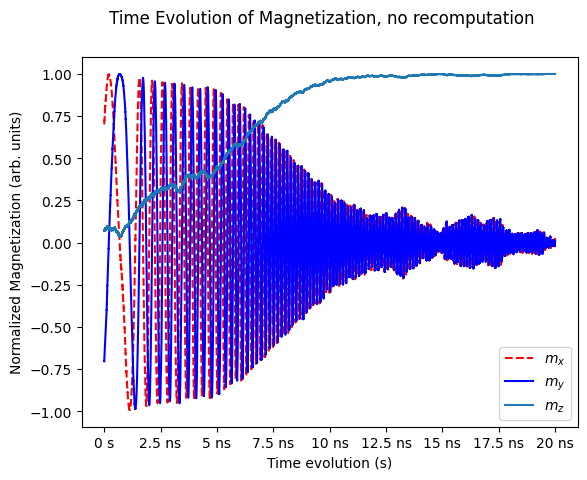

In [4]:
t_0 = time.time()
m0, t0 = calculate_magnetization(m0=np.array([1, -1, 0.1]), H_app=np.zeros(3), Tn=20e-9)
t_1 = time.time()
T_no_rec = t_1-t_0

fig, ax = plt.subplots()
ax.plot(t0, m0[:, 0], "r--", label=r"$m_x$")
ax.plot(t0, m0[:, 1], "b", label=r"$m_y$")
ax.plot(t0, m0[:, 2], label=r"$m_z$")

ax.xaxis.set_major_formatter(timeFormatter)
ax.set_xlabel("Time evolution (s)")
ax.set_ylabel("Normalized Magnetization (arb. units)")
ax.legend()
fig.suptitle("Time Evolution of Magnetization, no recomputation")

fig.show()
print(f"Time without recomputation: {T_no_rec:.0f} s")

2) Recomputing only the thermal field.

C:\Users\pietr\AppData\Local\Temp\ipykernel_10640\3092504208.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Time with H_th recomputation: 101 s


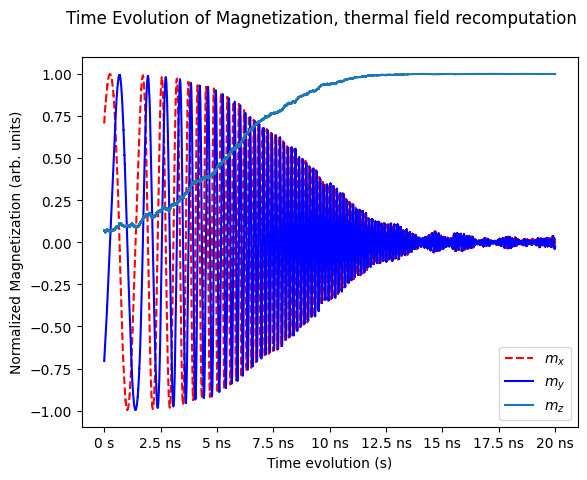

In [5]:
t_0 = time.time()
m1, t1 = calculate_magnetization(m0=np.array([1, -1, 0.1]), H_app=np.zeros(3), Tn=20e-9, recompute_H_th=True)
t_1 = time.time()
T_Hth = t_1-t_0

fig, ax = plt.subplots()
ax.plot(t1, m1[:, 0], "r--", label=r"$m_x$")
ax.plot(t1, m1[:, 1], "b", label=r"$m_y$")
ax.plot(t1, m1[:, 2], label=r"$m_z$")

ax.xaxis.set_major_formatter(timeFormatter)
ax.set_xlabel("Time evolution (s)")
ax.set_ylabel("Normalized Magnetization (arb. units)")
ax.legend()
fig.suptitle("Time Evolution of Magnetization, thermal field recomputation")

fig.show()
print(f"Time with H_th recomputation: {T_Hth:.0f} s")

3) Recomputing both thermal and effective fields.

C:\Users\pietr\AppData\Local\Temp\ipykernel_10640\1976983109.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Time with total field recomputation: 130 s


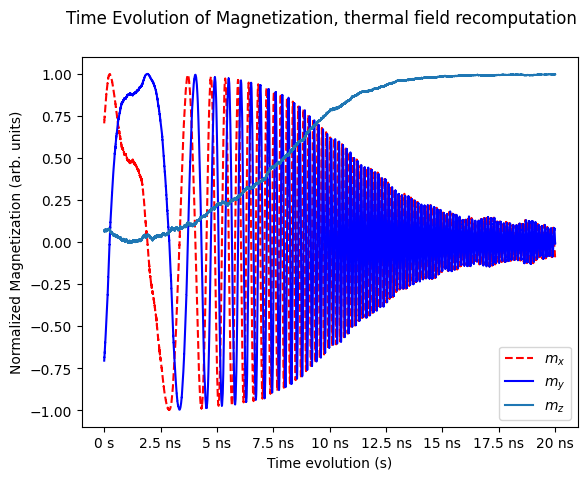

In [6]:
t_0 = time.time()
m2, t2 = calculate_magnetization(m0=np.array([1, -1, 0.1]), H_app=np.zeros(3), Tn=20e-9,
                                recompute_H_th=True,
                                recompute_H_eff=True)
t_1 = time.time()
T_Htot = t_1-t_0

fig, ax = plt.subplots()
ax.plot(t2, m2[:, 0], "r--", label=r"$m_x$")
ax.plot(t2, m2[:, 1], "b", label=r"$m_y$")
ax.plot(t2, m2[:, 2], label=r"$m_z$")

ax.xaxis.set_major_formatter(timeFormatter)
ax.set_xlabel("Time evolution (s)")
ax.set_ylabel("Normalized Magnetization (arb. units)")
ax.legend()
fig.suptitle("Time Evolution of Magnetization, thermal field recomputation")

fig.show()
print(f"Time with total field recomputation: {T_Htot:.0f} s")

C:\Users\pietr\AppData\Local\Temp\ipykernel_10640\4054550057.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Time without recomputation: 98 s
Time with H_th recomputation: 101 s
Time with total field recomputation: 130 s


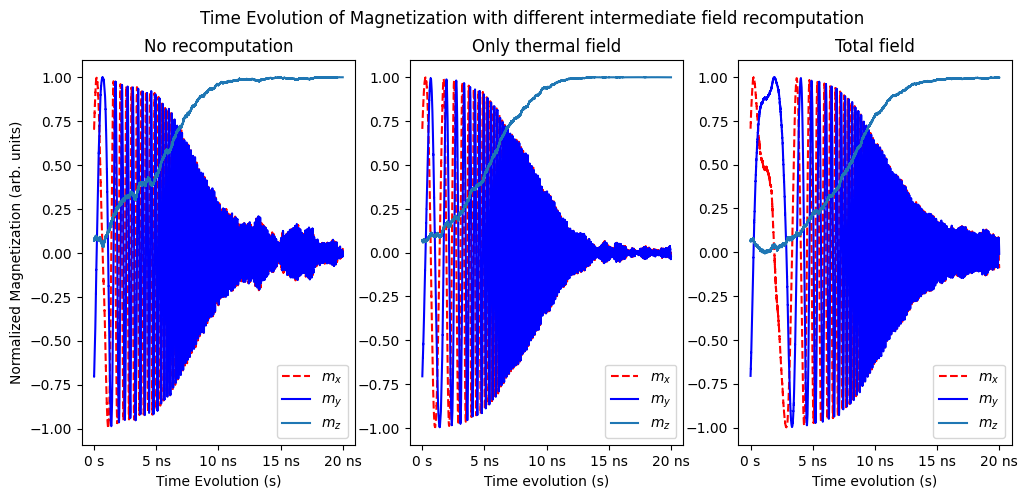

In [7]:
fig, ax = plt.subplots(1,3, figsize=(12, 5))
ax[0].plot(t0, m0[:, 0], "r--", label=r"$m_x$")
ax[0].plot(t0, m0[:, 1], "b", label=r"$m_y$")
ax[0].plot(t0, m0[:, 2], label=r"$m_z$")

ax[0].set_xlabel("Time Evolution (s)")
ax[0].set_ylabel("Normalized Magnetization (arb. units)")
ax[0].xaxis.set_major_formatter(timeFormatter)
ax[0].legend()
ax[0].set_title("No recomputation")

ax[1].plot(t1, m1[:, 0], "r--", label=r"$m_x$")
ax[1].plot(t1, m1[:, 1], "b", label=r"$m_y$")
ax[1].plot(t1, m1[:, 2], label=r"$m_z$")

ax[1].xaxis.set_major_formatter(timeFormatter)
ax[1].set_xlabel("Time evolution (s)")
#ax[1].set_ylabel("Normalized Magnetization (arb. units)")
ax[1].legend()
ax[1].set_title("Only thermal field")

ax[2].plot(t2, m2[:, 0], "r--", label=r"$m_x$")
ax[2].plot(t2, m2[:, 1], "b", label=r"$m_y$")
ax[2].plot(t2, m2[:, 2], label=r"$m_z$")

ax[2].xaxis.set_major_formatter(timeFormatter)
ax[2].set_xlabel("Time evolution (s)")
#ax[2].set_ylabel("Normalized Magnetization (arb. units)")
ax[2].legend()
ax[2].set_title("Total field")

fig.suptitle("Time Evolution of Magnetization with different intermediate field recomputation")

fig.show()
print(f"Time without recomputation: {T_no_rec:.0f} s")
print(f"Time with H_th recomputation: {T_Hth:.0f} s")
print(f"Time with total field recomputation: {T_Htot:.0f} s")

Since with the intermediate thermal field recomputation we are effectively averaging two random thermal fields with null mean value, it seems that the effect of the thermal field is slightly diminished with respect to the case where it is not recomputed. The extent of this change doesn't seem so big, especially considering that this kind of modeling is based on a statistical approximation, but it may require some more statistical analysis. For convenience and faster simulation times, one may keep the recomputations disabled.